In [ ]:
# This notebook handles data processing for the Faraday Rotation lab

# Imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [95]:
def linear_fit(x, m, b):
    return m * x + b

In [214]:
# Useful functions

# Reads a data file, returning a dictionary of its data
def read_file(file: str, axes: tuple) -> list[dict, dict]:
    
    # The data read
    data = {}
    
    # The uncertainty associated with the data
    uncs = {}
    
    # Initialises data dictionaries
    for axis in axes:
        data[axis] = []
        uncs[axis] = None
    
    
    # Reads the file
    with open(file + '.txt', "r") as file:
        
        # Tracks line number
        # Line 0 is metadata
        # Line 1 are the uncertainties
        # Lines 2+ is the data
        i = 0
        for line in file:
            
            # Deliminates each line with a comma
            split = line.split(',')
            
            # Handles the uncertainties
            if i == 1:
                for j in range(len(axes)):
                    uncs[axes[j]] = float(split[j + 1])

            
            # Third line is the start of the data
            elif i > 1:
                for j in range(len(axes)):
                    data[axes[j]].append(float(split[j]))
                
            # Increments to next line
            i += 1
            
            
    # Reshapes uncertainties to be the same length as the data
    for axis in uncs:
        uncs[axis] = [uncs[axis] for point in data[axis]]
            
            
    # Returns
    return data, uncs

# Plots data
def plot(data, x_axis, y_axis, title, labels = None, is_fit = True, save = False, scales = None, colour = None):
        
        if not colour:
            colour = 'tab:blue'
        
        # Obtains the figure components
        fig, ax = plt.subplots()

        # Obtains the x-values
        x = data.data[x_axis]
        x_unc = data.uncs[x_axis]


        # Obtains the y-values
        y = data.data[y_axis]
        y_unc = data.uncs[y_axis]
        
        # Adjusts the scale of the axis
        if scales:
            x = [point * scales[0] for point in x]
            x_unc = [upoint * scales[0] for upoint in x_unc]
            
            y = [point * scales[1] for point in y]
            y_unc = [upoint * scales[1] for upoint in y_unc]

        # Plots the data
        ax.scatter(x, y, color = colour)    
        
        # Plots the errors
        ax.errorbar(x, y, xerr = x_unc, yerr = y_unc, linestyle = "None", color = colour)

        # Adds axis titles
        if not labels:
            plt.xlabel(x_axis)
            plt.ylabel(y_axis)
        else:
            plt.xlabel(labels[0])
            plt.ylabel(labels[1])
        
        # Adds a title
        plt.title(title)
        
        
        # Performs a linear fit (if desired)
        if is_fit:

            # Performs the linear fit
            a_fit, uncs = fit(x, y, linear_fit, y_unc = y_unc)
            
            # Creates 
            lin_x = x
            lin_y = [linear_fit(i, a_fit[0], a_fit[1]) for i in lin_x]
            
            ax.plot(lin_x, lin_y, color = 'tab:orange', linewidth = 1, label = 'With Outlier')
            
            
            
            x = x[:-1]
            y = y[:-1]
            x_unc = x_unc[:-1]
            y_unc = y_unc[:-1]
            a_fit, uncs = fit(x, y, linear_fit, y_unc = y_unc)
            
            # Creates 
            lin_x = x
            lin_y = [linear_fit(i, a_fit[0], a_fit[1]) for i in lin_x]
            
            ax.plot(lin_x, lin_y, color = colour, linewidth = 1, label = 'Without Outlier')
            
        
        # Adds some custom lines
        if y_axis == 'volts':
            plt.axvline(x = 3.5, c = "k", linestyle = "--", linewidth = 0.5, label = "Solenoid Border")
        elif y_axis == 'teslas':
            plt.axvline(x = 7.5, c = "k", linestyle = "--", linewidth = 1, label = "Solenoid Border")
            plt.axvline(x = 12.5, c = "k", linestyle = "--", linewidth = 0.5, label = "Extent of Water Tube")
            
            #plt.axhline(y = 3.57, c = "k", linestyle = "--", linewidth = 1, label = "Average $B$ within Extent")
            #1.55e-03 ± 8.35e-05
            #3.57e-03?
            
        
        # Shows the legend
        ax.legend()
        

        # Shows (or saves) the graph
        if not save:
            plt.show()
        else:
            plt.savefig(title + '.png', bbox_inches='tight')
            
def fit(x, y, fcn, y_unc = None):

    
    # Performs the fit
    if not y_unc:
        a_fit, cov = curve_fit(fcn, x, y)
    else:
        a_fit, cov = curve_fit(fcn, x, y, sigma = y_unc)

    # Obtains the important parameters from the linear fit
    slope = a_fit[0]
    intercept = a_fit[1]

    # Obtains the uncertainty of the slope and intercept
    # Uncertainty is the square-root of the diagonal elements
    uncs = [np.sqrt(cov[i][i]) for i in range(len(cov))]

    return a_fit, uncs

In [215]:
# Contains our data
class Data:
    def __init__(self, file, axes):
        self.name = file
        self.data, self.uncs = read_file(file, axes)
        
    def transform(self, axis, new_axis, params, fcn, unc_fcn):
        self.data[new_axis] = []
        self.uncs[new_axis] = []
        
        for i in range(len(self.data[axis])):
            self.data[new_axis].append(fcn(self.data[axis][i], params))
            self.uncs[new_axis].append(unc_fcn(self.data[axis][i], self.uncs[axis][i], params))
        

In [216]:
# Data transforms
def transform_mag(V_out, params):
    return V_numerator(V_out, params) * V_denominator(V_out, params) / 2

def transform_umag(V_out, dV_out, params):
    return 1 / 2 * np.sqrt((dV_out * unc_B_VOUT(V_out, params)) ** 2 + (params['dV_Q'] * unc_B_VQ(V_out, params)) ** 2 + (params['dS_C'] * unc_B_SC(V_out, params)) ** 2 + (params['dS_TC'] * unc_B_STC(V_out, params)) ** 2 + (params['dT_A'] * unc_B_TA(V_out, params)) ** 2)

def unc_B_VOUT(V_out, params):
    return 1 * V_denominator(V_out, params)

def unc_B_VQ(V_out, params):
    return -1 * V_denominator(V_out, params)

def unc_B_SC(V_out, params):
    return -1 * V_numerator(V_out, params) / (params['S_C'] ** 2 * (1 + params['S_TC'] * (params['T_A'] - 25)))

def unc_B_STC(V_out, params):
    return -1 * (params['T_A'] - 25) * V_numerator(V_out, params) / (params['S_C'] * (1 + params['S_TC'] * (params['T_A'] - 25)) ** 2)

def unc_B_TA(V_out, params):
    return -1 * params['S_TC'] * V_numerator(V_out, params) / (params['S_C'] * (1 + params['S_TC'] * (params['T_A'] - 25)) ** 2)

def V_numerator(V_out, params):
    return V_out - params['V_Q']

def V_denominator(V_out, params):
    return 1 / (params['S_C'] * (1 + params['S_TC'] * (params['T_A'] - 25)))



def transform_amps(amp, params):
    return amp * params['B']

def transform_uamps(amp, uamp, params):
    return uamp * params['B']


def transform_degrees(degree, params):
    return degree * np.pi / 180

def transform_udegrees(degree, udegree, params):
    return udegree * np.pi / 180


def transform_position(position, params):
    return -1 * (position - 11)

def transform_uposition(position, uposition, params):
    return uposition


def trasnform_scale(value, scale):
    return value * scale

def trasnform_scale(value, uvalue, scale):
    return uvalue * scale


def transform_RMS(RMS_I, params):
    return RMS_I * np.sqrt(2)

def transform_uRMS(RMS_I, uRMS_I, params):
    return uRMS_I * np.sqrt(2)

In [217]:
# Reads the data
mag_file = 'mag'
m_files = ['day1', 'day2'] 
l_files = ['ac1', 'ac2', 'green_water', 'green_water2', 'green_rod', 'violet_rod']

glass = ['ac1', 'green_rod', 'violet_rod']
water = ['ac2', 'green_water', 'green_water2']

mag = Data(mag_file, ['position', 'volts'])
m_data = [Data(file, ['amps', 'volts', 'degrees']) for file in m_files]
#l_data = [Data(file, ['amps', 'I_0', 'RMS_∆I']) for file in l_files]
l_data = [Data(file, ['amps', 'I_0', '∆I']) for file in l_files]

In [218]:
# Transforms our data

# Converts magnetic to a field from 1 Amp
V_Q = 2.5
dV_Q = 0.7 / 100 * V_Q
S_C = 50
dS_C = 2.5 / 100 * S_C
S_TC = 0.12
dS_TC = 0.08 / 100 * S_TC
T_A = 40.5
dT_A = 0.05 / 100 * T_A


mag_params = {
    'V_Q': V_Q,
    'dV_Q': dV_Q,
    'S_C': S_C,
    'dS_C': dS_C,
    'S_TC': S_TC,
    'dS_TC': dS_TC,
    'T_A': T_A,
    'dT_A': dT_A
}

mag.transform('volts', 'teslas', mag_params, transform_mag, transform_umag)
B = mag.data['teslas'][0]


# Converts degrees to radians
for data in m_data:
    data.transform('degrees', 'radians', {}, transform_degrees, transform_udegrees)


# Converts amps to teslas
amps_params = {
    'B': B
}
    

# Convert amps to B
for data in m_data:
    data.transform('amps', 'teslas', amps_params, transform_amps, transform_uamps)

for data in l_data:
    data.transform('amps', 'teslas', amps_params, transform_amps, transform_uamps)
    
# Converts Hall Probe position to start at the centre of the
mag.transform('position', 'position0', {}, transform_position, transform_uposition)

# Converts ∆I from RMS to non-RMS
#for data in l_data:
#    data.transform('RMS_∆I', '∆I', {}, transform_RMS, transform_uRMS)

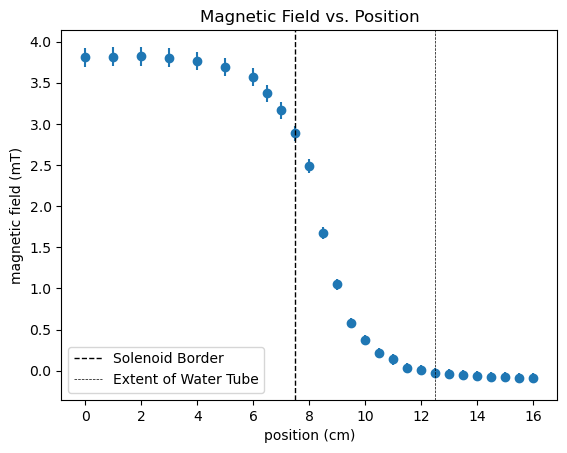

In [219]:
# Plots our data
show_plots = True
save = True
#colour = 'tab:blue'
colour = 'tab:orange'

if show_plots:

#    plot(mag, 'position', 'volts', 'Hall Probe Output Voltage vs. Position', labels = ['position (cm)', 'output voltage (V)'], is_fit = False, save = save, colour = 'tab:orange')
    plot(mag, 'position0', 'teslas', 'Magnetic Field vs. Position', labels = ['position (cm)', 'magnetic field (mT)'], is_fit = False, save = save, scales = [1, 1000])

#    for data in m_data:
#        plot(data, 'teslas', 'radians', data.name)
#    plot(m_data[0], 'teslas', 'degrees', 'Extinction Method with Red Laser', labels = ['magnetic field (mT)', 'polarization rotation (degrees)'], scales = [1000, 1], save = save)
#    plot(m_data[1], 'teslas', 'degrees', 'To-45 Method with Red Laser', labels = ['magnetic field (mT)', 'polarization rotation (degrees)'], scales = [1000, 1], save = save, colour = colour)

    #for data in l_data:
    #    plot(data, '∆I', 'teslas', data.name)
    
#    plot(l_data[0], 'teslas', '∆I', 'AC Lock-in through Glass with Red Laser', labels = ['magnetic field (mT)', 'intensity (Wm$^{-2}$)'], scales = [1000, 1], save = save, colour = 'tab:red')
#    plot(l_data[1], 'teslas', '∆I', 'AC Lock-in through Water with Red Laser', labels = ['magnetic field (mT)', 'intensity (Wm$^{-2}$)'], scales = [1000, 1], save = save, colour = colour)

#    plot(l_data[3], 'teslas', '∆I', 'AC Lock-in through Water with Green Laser', labels = ['magnetic field (mT)', 'intensity (Wm$^{-2}$)'], scales = [1000, 1], save = save, colour = colour)
#    plot(l_data[4], 'teslas', '∆I', 'AC Lock-in through Glass with Green Laser', labels = ['magnetic field (mT)', 'intensity (Wm$^{-2}$)'], scales = [1000, 1], save = save, colour = 'green')
#    plot(l_data[5], 'teslas', '∆I', 'AC Lock-in through Glass with Violet Laser', labels = ['magnetic field (mT)', 'intensity (Wm$^{-2}$)'], scales = [1000, 1], save = save, colour = colour)

In [121]:
def print_v(data, verdet, uverdet):
    # Convets the verdet constant to a string
    str_verdet = f'{verdet:.4e}'
    str_uverdet = f'{uverdet:.4e}'
    
    # Grabs the exponent
    mantissa = str_verdet.split('e')[0]
    exponent = str_verdet.split('e')[1]
    float_exponent = float(exponent)
    
    umantissa = str_uverdet.split('e')[0]
    uexponent = str_uverdet.split('e')[1]
    float_uexponent = float(uexponent)
    
    # Get the difference in magnitudes
    diff = float_exponent - float_uexponent
    
    # Converts uverdet to the same base
    rebase_uverdet = round(float(umantissa) / (10 ** diff), 4)
    
    # Prints it all out
    print(f'\n\n{data.name}:')
    print(f'({mantissa} ± {rebase_uverdet})e{exponent}')

In [154]:
# Calculates values
L_glass = 10e-2
L_water = 25e-2

# Prints magnetic field values with uncertaintyprint(B)
B_unc = mag.uncs['teslas'][0]
print(f'{mag.name}:\t{B:.2e} ± {B_unc:.2e}')

# Calculates the average magnetic field over the position of the glass rod
#B_ave = np.average([mag.data['teslas'][i] for i in range(len(mag.data['teslas'])) if mag.data['position'][i] < 12])
#B_ave_unc_arr = [mag.uncs['teslas'][i] ** 2 for i in range(len(mag.uncs['teslas'])) if mag.data['position'][i] < 12]

B_ave = np.average([mag.data['teslas'][i] for i in range(len(mag.data['teslas'])) if mag.data['position'][i] >= 3.5])
B_ave_unc_arr = [mag.uncs['teslas'][i] ** 2 for i in range(len(mag.uncs['teslas'])) if mag.data['position'][i] >= 3.5]

B_ave_unc = np.sqrt(sum(B_ave_unc_arr) / len(B_ave_unc_arr))
print(f'{mag.name}:\t{B_ave:.2e} ± {B_ave_unc:.2e}')
print(len([mag.data['teslas'][i] for i in range(len(mag.data['teslas'])) if mag.data['position'][i] >= 3.5]))


# Calculates verdet from manual trials
for data in m_data:
    a_fit, uncs = fit(data.data['teslas'], data.data['radians'], linear_fit)
    slope = a_fit[0]
    
    verdet = slope / L_glass / 2
    
    # Only one source of uncertainty: the slope
    verdet_unc = np.sqrt((uncs[0] / L_glass) ** 2)
    print_v(data, verdet, verdet_unc)
    

# Calculates verdet from lockin trials
for data in l_data:
    
    # Averages I_0 values
    I_0 = 0
    for point in data.data['I_0']:
        I_0 += point / len(data.data['I_0'])
        
    # Gets the uncertainty of I_0, its standard error
    I_0_se = np.std(data.data['I_0']) / np.sqrt(len(data.data['I_0']))
    
    
    # Calculates the prefactor
    if data.name in glass:
        prefactor = 2 * L_glass * I_0
    elif data.name in water:
        prefactor = 2 * L_water * I_0
    else:
        print(data.name, 'not matched!')

    # Gets the slope from the sit
    a_fit, uncs = fit(data.data['teslas'], data.data['∆I'], linear_fit, data.uncs['∆I'])
    #a_fit, uncs = fit(data.data['teslas'], data.data['∆I'], linear_fit)
    slope = a_fit[0]

    # I don't know why, but I've got the inverse here...
    verdet = prefactor * slope
    
    # Fixes the water tube extending into the fringe
    if data.name in water:
        verdet *= B_ave / B
        
    
    # We only have two sources of uncertainty: I_0 and the slope
    if data.name in water:
        L = L_water
    else:
        L = L_glass
    verdet_unc = np.sqrt((2 * L * slope * I_0_se) ** 2 + (2 * L * I_0 * uncs[0]) ** 2)
    
    print_v(data, verdet, verdet_unc)

mag:	3.81e-03 ± 1.13e-04
mag:	3.57e-03 ± 1.09e-04
10


day1:
(2.8837 ± 0.2241)e+01


day2:
(2.5689 ± 0.2717)e+01


ac1:
(2.3759 ± 0.0051)e+01


ac2:
(7.7189 ± 0.0342)e+00


green_water:
(1.2933 ± 0.1384)e-03


green_water2:
(1.6388 ± 0.1104)e-03


green_rod:
(7.6645 ± 0.554)e-01


violet_rod:
(1.1365 ± 0.0618)e-01


NameError: name 'x_axis' is not defined

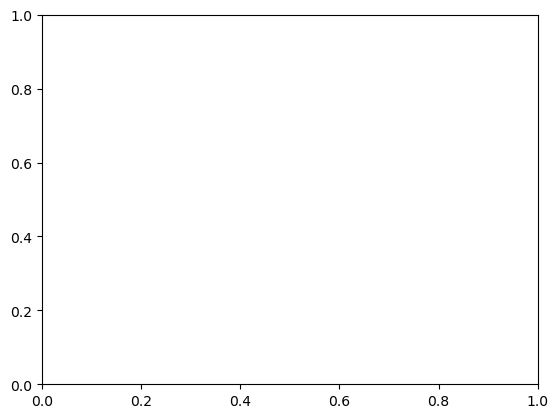

In [107]:
# Creates a scatter plot of Verdet constants for the glass rod
# Obtains the figure components


fig, ax = plt.subplots()

# Obtains the x-values
x = data.data[x_axis]
x_unc = data.uncs[x_axis]


# Obtains the y-values
y = data.data[y_axis]
y_unc = data.uncs[y_axis]

# Adjusts the scale of the axis
if scales:
    x = [point * scales[0] for point in x]
    x_unc = [upoint * scales[0] for upoint in x_unc]

    y = [point * scales[1] for point in y]
    y_unc = [upoint * scales[1] for upoint in y_unc]

# Plots the data
ax.scatter(x, y)    

# Plots the errors
ax.errorbar(x, y, xerr = x_unc, yerr = y_unc, linestyle = "None", color = 'tab:blue')

# Adds axis titles
if not labels:
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
else:
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

# Adds a title
plt.title(title)